# Time processing for every ONNX nodes in a graph

The following notebook show how long the runtime spends in each node of an ONNX graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## LogisticRegression

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
import numpy
from mlprodict.onnxrt import to_onnx
onx = to_onnx(clr, X_test.astype(numpy.float32))
# add -l 1 if nothing shows up
%onnxview onx

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


In [5]:
from mlprodict.onnxrt import OnnxInference
import pandas
oinf = OnnxInference(onx)
res = oinf.run({'X': X_test}, node_time=True)
pandas.DataFrame(list(res[1]))

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.017172
1,1,Normalizer,Normalizer,0.000081
2,2,Cast,Cast,0.000014
3,3,ZipMap,ZipMap,0.000012


In [6]:
oinf.run({'X': X_test})['output_probability'][:5]

{0: array([0.01090865, 0.00096206, 0.00128516, 0.00039008, 0.01844841]),
 1: array([0.6227364 , 0.29084701, 0.37692534, 0.41041315, 0.84288572]),
 2: array([0.36635495, 0.70819092, 0.62178949, 0.58919676, 0.13866587])}

## Logistic regression: python runtme vs onnxruntime

In [7]:
from mlprodict.onnxrt.validate import enumerate_validated_operator_opsets
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-cl"))

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


In [8]:
import pandas
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
df

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,LinearClassifier,LinearClassifier,0.000024,1,0.000073,0.000013,20,20,0-LinearClassifier
1,1,Normalizer,Normalizer,0.000022,1,0.000075,0.000012,20,20,1-Normalizer
2,2,Cast,Cast,0.000007,1,0.000019,0.000004,20,20,2-Cast
3,3,ZipMap,ZipMap,0.000006,1,0.000015,0.000003,20,20,3-ZipMap
4,0,LinearClassifier,LinearClassifier,0.000025,10,0.000040,0.000016,20,20,0-LinearClassifier
5,1,Normalizer,Normalizer,0.000020,10,0.000032,0.000013,20,20,1-Normalizer
6,2,Cast,Cast,0.000006,10,0.000009,0.000004,20,20,2-Cast
7,3,ZipMap,ZipMap,0.000005,10,0.000008,0.000003,20,20,3-ZipMap
8,0,LinearClassifier,LinearClassifier,0.000019,100,0.000020,0.000018,5,5,0-LinearClassifier
9,1,Normalizer,Normalizer,0.000016,100,0.000016,0.000016,5,5,1-Normalizer


Following tables shows the time spent in each node, it is relative to the total time. For one observation, the runtime spends 10% of the time in ZipMap, it is only 1% or 2% with 10 observations. These proportions change due to the computing cost of each node.

In [9]:
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.414133,0.437942,0.452107,0.485631,0.520633,0.538488
1-Normalizer,0.369531,0.357464,0.377011,0.428922,0.457003,0.427673
2-Cast,0.118019,0.109126,0.091284,0.047654,0.015290,0.032467
3-ZipMap,0.098317,0.095469,0.079598,0.037793,0.007074,0.001371


The python implementation of *ZipMap* does not change the data but wraps in into a frozen class ``ArrayZipMapDitionary`` which mocks a list of dictionaries *pandas* can ingest to create a DataFrame. The cost is a fixed cost and does not depends on the number of processed rows.

In [10]:
from pyquickhelper.pycode.profiling import profile
bigX = numpy.random.randn(100000, X_test.shape[1]).astype(numpy.float32)
df = profile(lambda: oinf.run({'X': bigX}), as_df=True)[1]
df['file'] = df['file'].apply(lambda s: s.split("GitHub")[-1])
df

,namefct,file,ncalls1,ncalls2,tin,cum_tin,tall,cum_tall
0,onnx_inference.py:313-run,\mlprodict\mlprodict\onnxrt\onnx_inference.py:313,2,2,2.031000e-04,3.808000e-04,4.484710e-02,6.735950e-02
1,371-_run_sequence_runtime,\mlprodict\mlprodict\onnxrt\onnx_inference.py:371,7,7,9.170000e-05,1.171000e-04,4.464400e-02,6.697870e-02
2,onnx_inference_node.py:109-run,\mlprodict\mlprodict\onnxrt\onnx_inference_nod...,24,24,8.920000e-05,1.531000e-04,4.454990e-02,6.685680e-02
3,_op.py:169-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:169,4,4,1.030310e-02,1.030850e-02,4.375240e-02,6.563130e-02
4,_op.py:282-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:282,2,2,9.800000e-06,1.700000e-05,3.023620e-02,4.535790e-02
5,<ipython-input-10-d4f3af6cfacf>:3-<lambda>,<ipython-input-10-d4f3af6cfacf>:3,2,2,1.821000e-04,1.821000e-04,4.502920e-02,4.502920e-02
6,op_linear_classifier.py:37-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_linear_...,3,3,1.030570e-02,2.060080e-02,1.992870e-02,3.504060e-02
7,_op.py:249-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:249,2,2,7.300000e-06,1.180000e-05,1.353330e-02,2.030220e-02
8,op_normalizer.py:46-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_normali...,2,2,4.140600e-03,4.143200e-03,1.352060e-02,2.028220e-02
9,op_normalizer.py:34-norm_l1,\mlprodict\mlprodict\onnxrt\ops_cpu\op_normali...,3,3,4.150500e-03,8.288500e-03,9.380000e-03,1.613900e-02


In [11]:
%matplotlib inline

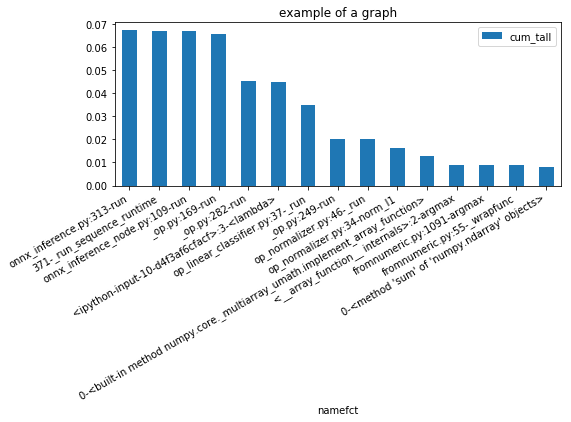

In [12]:
ax = df[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(kind='bar', figsize=(8, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');

The class *ArrayZipMapDictionary* is fast to build but has an overhead after that because it builds data when needed.

In [13]:
res = oinf.run({'X': bigX})
prob = res['output_probability']
type(prob)

mlprodict.onnxrt.ops_cpu.op_zipmap.ArrayZipMapDictionary

In [14]:
%timeit pandas.DataFrame(prob)

1.14 s ± 62.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
list_of_dict = [v.asdict() for v in prob]
%timeit pandas.DataFrame(list_of_dict)

191 ms ± 8.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


But if you just need to do the following:

In [16]:
%timeit pandas.DataFrame(prob).values

1.19 s ± 63.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Then, you can just do that:

In [17]:
print(prob.columns)
%timeit prob.values

[0, 1, 2]
290 ns ± 38.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


And then:


In [18]:
%timeit pandas.DataFrame(prob.values, columns=prob.columns)

293 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We can then compare to what *onnxruntime* would do when the runtime is called indenpently for each node:

In [19]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True))
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.296104,0.284067,0.220448,0.140208,0.106234,0.083833
1-Normalizer,0.238504,0.231494,0.160045,0.066393,0.041630,0.033969
2-Cast,0.236933,0.213220,0.134577,0.027722,0.006012,0.005975
3-ZipMap,0.228459,0.271219,0.484931,0.765678,0.846123,0.876224


*onnxruntime* creates a new container each time a ZipMap is executed. That's whay it takes that much time and the ratio increases when the number of observations increases.

## GaussianProcessRegressor

This operator is slow for small batches compare to *scikit-learn* but closes the gap as the batch size increases. Let's see where the time goes.

In [20]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

In [21]:
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
df.head()

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,Sc_Scan,Scan,0.008009,1,0.010148,0.006611,20,20,00-Sc_Scan
1,1,kgpd_Transpose,Transpose,0.000018,1,0.000023,0.000014,20,20,01-kgpd_Transpose
2,2,kgpd_Sqrt,Sqrt,0.000016,1,0.000021,0.000013,20,20,02-kgpd_Sqrt
3,3,kgpd_Div,Div,0.000015,1,0.000020,0.000012,20,20,03-kgpd_Div
4,4,kgpd_Mul,Mul,0.000012,1,0.000020,0.000009,20,20,04-kgpd_Mul


In [22]:
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,0.979837,0.968406,0.900054,0.648007,0.406872,0.517711
01-kgpd_Transpose,0.002199,0.002778,0.001987,0.001037,0.000256,0.000018
02-kgpd_Sqrt,0.002014,0.002710,0.002579,0.003284,0.004233,0.002960
03-kgpd_Div,0.001777,0.002376,0.002116,0.003525,0.027073,0.019976
04-kgpd_Mul,0.001449,0.001558,0.001696,0.003399,0.029361,0.018748
05-kgpd_Sin,0.001873,0.005133,0.023191,0.086682,0.136754,0.136037
06-kgpd_Div1,0.001270,0.001542,0.002079,0.005264,0.029150,0.019803
07-kgpd_Pow,0.002000,0.005915,0.038587,0.177073,0.261514,0.195407
08-kgpd_Mul1,0.001206,0.001482,0.003501,0.007191,0.024513,0.020254


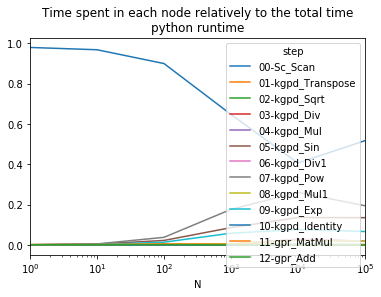

In [23]:
ax = (piv / total).T.plot(logx=True)
ax.set_title("Time spent in each node relatively to the total time\npython runtime");

The operator is clearly time consuming when the batch size is small. *onnxruntime* is more efficient for this one.

In [24]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

In [25]:
try:
    df = pandas.DataFrame(res[0]['bench-batch'])
except KeyError as e:
    raise RuntimeError("No model available in\n{}".format(df)) from e
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,0.770063,0.748283,0.668856,0.463243,0.341807,0.351295
01-kgpd_Transpose,0.023065,0.027911,0.059234,0.105450,0.096643,0.098369
02-kgpd_Sqrt,0.016525,0.017217,0.016525,0.028317,0.044699,0.064769
03-kgpd_Div,0.019999,0.019514,0.016067,0.025404,0.041261,0.044687
04-kgpd_Mul,0.020128,0.019421,0.016236,0.025854,0.042249,0.041210
05-kgpd_Sin,0.017760,0.029868,0.091776,0.163665,0.148420,0.146222
06-kgpd_Div1,0.019329,0.019298,0.017427,0.026389,0.044010,0.038109
07-kgpd_Pow,0.020059,0.019923,0.016189,0.024973,0.042777,0.037524
08-kgpd_Mul1,0.019329,0.020213,0.015418,0.025177,0.045088,0.035691


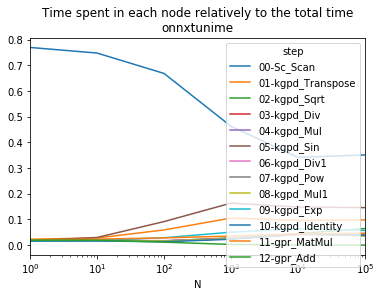

In [26]:
ax = (piv / total).T.plot(logx=True)
ax.set_title("Time spent in each node relatively to the total time\nonnxtunime");